# Imports and Datasets

In [1]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import random_split
from tqdm import tqdm
import lightning as L
import matplotlib.pyplot as plt
import torchmetrics


In [2]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [ ]:
Noise_0_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_syn_train_0_0_.csv"
)
Noise_Low_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_synA_train_shuffled.csv"
)
Noise_High_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_synA_test_hard_shuffled_sample.csv"
)

if Noise_0_data.status_code == 200 and Noise_Low_data.status_code == 200 and Noise_High_data.status_code == 200:
    datafolder = "Data/Assignment1"

    if not os.path.exists(datafolder):
        os.makedirs(datafolder)

    with open(os.path.join(datafolder, "data_0_noise"), "wb") as f:
        f.write(Noise_0_data.text.encode("utf-8"))

    with open(os.path.join(datafolder, "data_Low_noise"), "wb") as f:
        f.write(Noise_Low_data.text.encode("utf-8"))

    with open(os.path.join(datafolder, "data_High_noise"), "wb") as f:
        f.write(Noise_High_data.text.encode("utf-8"))
else:
    print("Error in fetching data")

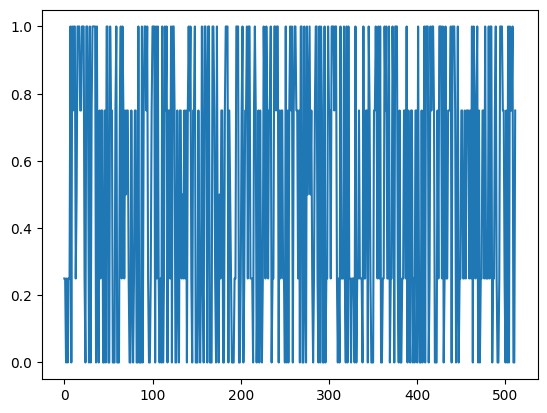

In [3]:
Noise_0_dataframe = pd.read_csv("../Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("../Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("../Data/Assignment1/data_High_noise")
Noise_Low_dataframe = Noise_Low_dataframe.sort_values(by = ["row_num","day"])
Noise_High_dataframe = Noise_High_dataframe.sort_values(by = ['row_num',"day"])
# plt.plot(range(1000),Noise_Low_dataframe["day"][:1000])
# plt.plot(range(1000),Noise_Low_dataframe["row_num"][:1000])
plt.plot(range(512),Noise_High_dataframe["target_10_val"][:512])

In [4]:
Noise_0_dataframe.head()

,Open_n_val,High_n_val,Low_n_val,Close_n_val,Volume_n_val,SMA_10_val,SMA_20_val,CMO_14_val,High_n-Low_n_val,Open_n-Close_n_val,...,Open_n-Close_n_changelen_val,SMA_20-SMA_10_changelen_val,Close_n_slope_3_changelen_val,Close_n_slope_5_changelen_val,Close_n_slope_10_changelen_val,row_num,day,era,target_10_val,target_5_val
0,0.5,0.5,0.5,0.5,0.0,0.5,0.25,1.0,1.0,0.5,...,0.50,0.75,0.25,0.75,0.50,75,537,2,0.75,0.75
1,0.5,0.5,0.5,0.5,0.0,0.5,0.50,1.0,1.0,0.5,...,0.50,0.50,0.75,0.50,0.50,76,537,2,0.75,0.75
2,0.5,0.5,0.5,0.5,0.0,0.5,0.50,1.0,1.0,0.5,...,0.50,0.25,0.50,0.50,0.75,77,537,2,0.75,0.75
3,0.5,0.5,0.5,0.5,0.0,0.5,0.50,1.0,1.0,0.5,...,0.25,0.25,0.50,0.75,0.50,78,537,2,0.75,0.75
4,0.5,0.5,0.5,0.5,0.0,0.5,0.50,1.0,1.0,0.5,...,0.75,0.25,0.50,0.50,0.50,79,537,2,0.75,0.75


In [5]:
Noise_0_dataframe.columns

Index(['Open_n_val', 'High_n_val', 'Low_n_val', 'Close_n_val', 'Volume_n_val',
       'SMA_10_val', 'SMA_20_val', 'CMO_14_val', 'High_n-Low_n_val',
       'Open_n-Close_n_val', 'SMA_20-SMA_10_val', 'Close_n_slope_3_val',
       'Close_n_slope_5_val', 'Close_n_slope_10_val', 'Open_n_changelen_val',
       'High_n_changelen_val', 'Low_n_changelen_val', 'Close_n_changelen_val',
       'High_n-Low_n_changelen_val', 'Open_n-Close_n_changelen_val',
       'SMA_20-SMA_10_changelen_val', 'Close_n_slope_3_changelen_val',
       'Close_n_slope_5_changelen_val', 'Close_n_slope_10_changelen_val',
       'row_num', 'day', 'era', 'target_10_val', 'target_5_val'],
      dtype='object')

In [6]:
class_index = list(Noise_0_dataframe["era"].unique())
class_index_noise = list(Noise_Low_dataframe["era"].unique())
class_index_t10v_noise = list(Noise_Low_dataframe["target_10_val"].unique())

def encode(value, class_index = class_index):
    return class_index.index(value)

def encode_noise(value, class_index = class_index_noise):
    return class_index.index(value)

def encode_noise_t10v(value, class_index = class_index_t10v_noise):
    return class_index.index(value)


Noise_0_dataframe["era"] = Noise_0_dataframe["era"].apply(encode)
Noise_Low_dataframe["era"] = Noise_Low_dataframe["era"].apply(encode_noise)
Noise_High_dataframe["era"] = Noise_High_dataframe["era"].apply(encode_noise)
Noise_Low_dataframe["target_10_val"] = Noise_Low_dataframe["target_10_val"].apply(encode_noise_t10v)
Noise_High_dataframe["target_10_val"] = Noise_High_dataframe["target_10_val"].apply(encode_noise_t10v)

In [119]:
class SequentialDataset(Dataset):
    def __init__(self,dataframe,noise,target, sequence_length = 12, drop = None):
        self.dataset = dataframe.drop(drop,axis=1)
        self.target = target
        self.sequence_length = sequence_length
    
    def __len__(self):
        return len(self.dataset)-self.sequence_length+1

    def __getitem__(self, index):
        sequence = self.dataset[index:index+self.sequence_length]
        input = sequence.drop(self.target,axis =1).values
        target = sequence[self.target].values
        return input,target

In [120]:
#Setting up datasets
Noise_0_dataset_era = SequentialDataset(Noise_0_dataframe, "0",drop = ["row_num","day","target_10_val","target_5_val"], target = "era")
Noise_Low_dataset_era = SequentialDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_5_val","data_type"], target = "era")
Noise_High_dataset_era = SequentialDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_5_val","data_type"], target = "era")
Noise_Low_dataset_t10v = SequentialDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_5_val","data_type"], target = "target_10_val")
Noise_High_dataset_t10v = SequentialDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_5_val","data_type"], target = "target_10_val")
Noise_0_train_era, Noise_0_test_era = random_split(Noise_0_dataset_era, [0.8,0.2])
Noise_Low_train_era, Noise_Low_test_era = random_split(Noise_Low_dataset_era, [0.8,0.2])
Noise_High_train_era, Noise_High_test_era = random_split(Noise_High_dataset_era, [0.8,0.2])
Noise_Low_train_t10v, Noise_Low_test_t10v = random_split(Noise_Low_dataset_t10v, [0.8,0.2])
Noise_High_train_t10v, Noise_High_test_t10v = random_split(Noise_High_dataset_t10v, [0.8,0.2])

In [121]:
#Setting up dataloaders
Noise_0_era_train_loader = DataLoader(Noise_0_train_era, batch_size=64, shuffle=True)
Noise_0_era_test_loader = DataLoader(Noise_0_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_Low_era_train_loader = DataLoader(Noise_Low_train_era, batch_size=64, shuffle=True)
Noise_Low_era_test_loader = DataLoader(Noise_Low_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_High_era_train_loader = DataLoader(Noise_High_train_era, batch_size=64, shuffle=True)
Noise_High_era_test_loader = DataLoader(Noise_High_test_era, batch_size=64, shuffle=True)
########################################################################################
Noise_Low_t10v_train_loader = DataLoader(Noise_Low_train_t10v, batch_size=2048, shuffle=True)
Noise_Low_t10v_test_loader = DataLoader(Noise_Low_test_t10v, batch_size=2048, shuffle=True)
########################################################################################
Noise_High_t10v_train_loader = DataLoader(Noise_High_train_t10v, batch_size=1024, shuffle=True)
Noise_High_t10v_test_loader = DataLoader(Noise_High_test_t10v, batch_size=1024, shuffle=True)
########################################################################################


# LSTM Model

In [123]:
class LSTMmodel(torch.nn.Module):
    def __init__(self, lstm_input_dims, lstm_hidden_size,lstm_num_layers,linear_dims,num_classes,linear_activation = torch.nn.ReLU()):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=lstm_input_dims,hidden_size=lstm_hidden_size,num_layers=lstm_num_layers,batch_first=True)
        self.layers = []
        self.att_layer = torch.nn.Linear(linear_dims[-1], 1)
        linear_layers = [torch.nn.Linear(linear_dims[i], linear_dims[i+1]) for i in range(len(linear_dims)-1)]
        for i in range(len(linear_layers)):
            if (i == len(linear_layers)-1):
                self.layers.append(linear_layers[i])
            else:
                self.layers.append(linear_layers[i])
                self.layers.append(linear_activation)
        
        self.layers = torch.nn.Sequential(*self.layers)
        self.lsoftmax = torch.nn.LogSoftmax(dim = 1)
        
    def forward(self,X):
        X, (hn,cn) = self.lstm(X)
        X = self.layers(X)
        X = self.lsoftmax(X)
        return X

In [122]:
def train_model_sequential(model, criterion, optimizer , train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            optimizer.zero_grad()
            output = model(inputs)
            output = output.view(-1,5)
            labels = labels.view(-1)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader):
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                output = model(inputs)
                output = output.view(-1,5)
                labels = labels.view(-1)
                loss = criterion(output, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(output, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


In [133]:
model = LSTMmodel(lstm_input_dims=24,lstm_hidden_size = 24, lstm_num_layers=1,num_classes = 5, linear_dims=[24,16,5], linear_activation = torch.nn.ELU())
model = model.to(device)
print(model)

LSTMmodel(
  (lstm): LSTM(24, 24, batch_first=True)
  (att_layer): Linear(in_features=5, out_features=1, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=16, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=16, out_features=5, bias=True)
  )
  (lsoftmax): LogSoftmax(dim=1)
)


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch [1/5], Train Loss: 2.1497, Train Acc: 0.5308, Val Loss: 2.0375, Val Acc: 0.5459


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch [2/5], Train Loss: 2.0086, Train Acc: 0.5437, Val Loss: 1.9880, Val Acc: 0.5468


100%|██████████| 49/49 [00:18<00:00,  2.64it/s]


Epoch [3/5], Train Loss: 1.9795, Train Acc: 0.5491, Val Loss: 1.9705, Val Acc: 0.5513


100%|██████████| 49/49 [00:18<00:00,  2.62it/s]


Epoch [4/5], Train Loss: 1.9658, Train Acc: 0.5534, Val Loss: 1.9611, Val Acc: 0.5550


100%|██████████| 49/49 [00:18<00:00,  2.63it/s]


Epoch [5/5], Train Loss: 1.9569, Train Acc: 0.5563, Val Loss: 1.9527, Val Acc: 0.5605


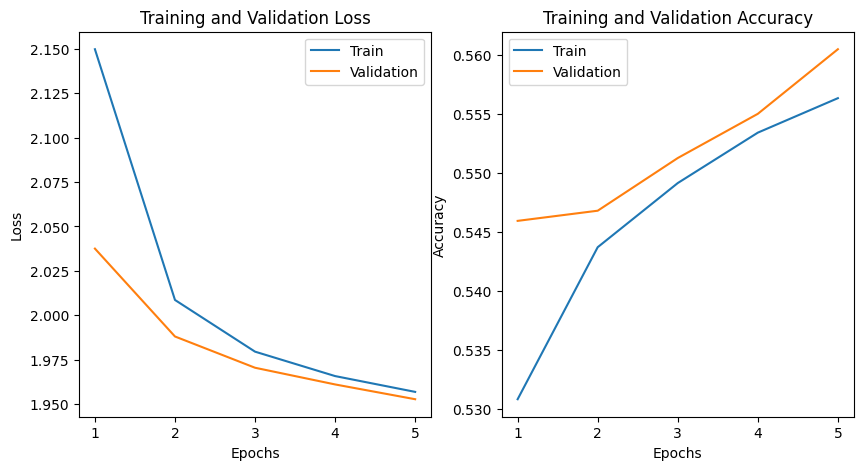

In [134]:
train_model_sequential(model,
            criterion = torch.nn.NLLLoss(), 
            optimizer=torch.optim.Adam(model.parameters(), lr=0.01), 
            train_loader=Noise_High_t10v_train_loader, 
            val_loader=Noise_High_t10v_test_loader, 
            num_epochs=5)

100%|██████████| 31/31 [00:20<00:00,  1.49it/s]


Epoch [1/5], Train Loss: 1.6536, Train Acc: 0.7034, Val Loss: 1.6361, Val Acc: 0.7088


100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


Epoch [2/5], Train Loss: 1.6302, Train Acc: 0.7112, Val Loss: 1.6251, Val Acc: 0.7126


100%|██████████| 31/31 [00:13<00:00,  2.31it/s]


Epoch [3/5], Train Loss: 1.6208, Train Acc: 0.7144, Val Loss: 1.6167, Val Acc: 0.7169


100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


Epoch [4/5], Train Loss: 1.6137, Train Acc: 0.7170, Val Loss: 1.6123, Val Acc: 0.7162


100%|██████████| 31/31 [00:18<00:00,  1.66it/s]


Epoch [5/5], Train Loss: 1.6082, Train Acc: 0.7185, Val Loss: 1.6058, Val Acc: 0.7208


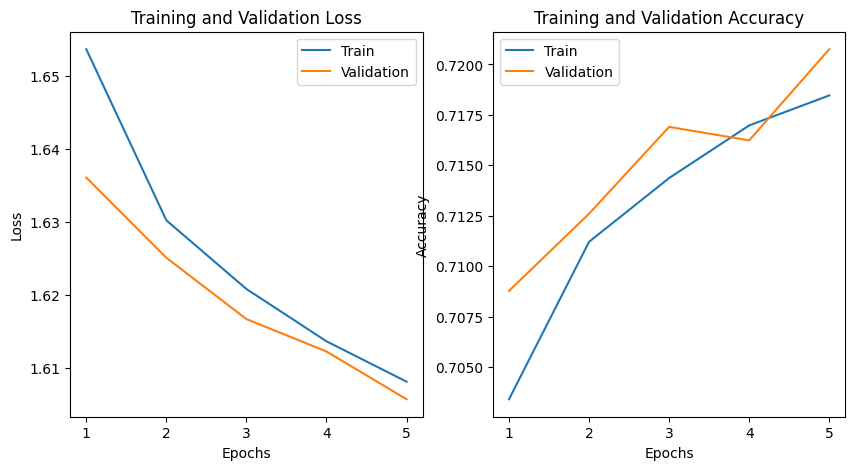

In [136]:
train_model_sequential(model,
            criterion = torch.nn.NLLLoss(), 
            optimizer=torch.optim.Adam(model.parameters(), lr=0.01), 
            train_loader=Noise_Low_t10v_train_loader, 
            val_loader=Noise_Low_t10v_test_loader, 
            num_epochs=5)

# Transformer Model

In [83]:
class TransformerModel (torch.nn.Module):
    def __init__(self,transformer_d_model,transformer_source_shape,transformer_target_shape, linear_layers, linear_activation = torch.nn.ReLU()):
        super().__init__()
        self.transformer = torch.nn.Transformer(d_model=transformer_d_model, batch_first=True, num_encoder_layers=2, num_decoder_layers=2, dropout=0.1,nhead=4)
        self.transformer_source_shape = transformer_source_shape
        self.transformer_target_shape = transformer_target_shape
        self.layers = []
        linear_layers = [torch.nn.Linear(linear_layers[i], linear_layers[i+1]) for i in range(len(linear_layers)-1)]
        for i in range(len(linear_layers)):
            if (i == len(linear_layers)-1):
                self.layers.append(linear_layers[i])
            else:
                self.layers.append(linear_layers[i])
                self.layers.append(linear_activation)
                
        self.layers = torch.nn.Sequential(*self.layers)
        self.lsoftmax = torch.nn.LogSoftmax(dim = 1)
    
    def forward(self,X):
        X = self.transformer(src = X, tgt = X)
        X = self.layers(X)
        X = self.lsoftmax(X)
        return X

In [86]:
representation_model = TransformerModel(transformer_d_model=24,transformer_source_shape = (1024,10,24),transformer_target_shape = (1024,10,24), linear_layers=[24,16,5])
representation_model = representation_model.to(device)

100%|██████████| 61/61 [00:27<00:00,  2.22it/s]


Epoch [1/10], Train Loss: 1.5321, Train Acc: 0.6947, Val Loss: 1.3785, Val Acc: 0.7435


100%|██████████| 61/61 [00:15<00:00,  3.90it/s]


Epoch [2/10], Train Loss: 1.3818, Train Acc: 0.7427, Val Loss: 1.3444, Val Acc: 0.7569


100%|██████████| 61/61 [00:15<00:00,  3.95it/s]


Epoch [3/10], Train Loss: 1.3582, Train Acc: 0.7527, Val Loss: 1.3268, Val Acc: 0.7658


100%|██████████| 61/61 [00:16<00:00,  3.60it/s]


Epoch [4/10], Train Loss: 1.3451, Train Acc: 0.7581, Val Loss: 1.3189, Val Acc: 0.7668


100%|██████████| 61/61 [00:16<00:00,  3.81it/s]


Epoch [5/10], Train Loss: 1.3364, Train Acc: 0.7621, Val Loss: 1.3101, Val Acc: 0.7690


100%|██████████| 61/61 [00:15<00:00,  3.87it/s]


Epoch [6/10], Train Loss: 1.3283, Train Acc: 0.7659, Val Loss: 1.3025, Val Acc: 0.7754


100%|██████████| 61/61 [00:18<00:00,  3.31it/s]


Epoch [7/10], Train Loss: 1.3225, Train Acc: 0.7687, Val Loss: 1.3023, Val Acc: 0.7746


100%|██████████| 61/61 [00:29<00:00,  2.05it/s]


Epoch [8/10], Train Loss: 1.3173, Train Acc: 0.7714, Val Loss: 1.2951, Val Acc: 0.7769


100%|██████████| 61/61 [00:16<00:00,  3.62it/s]


Epoch [9/10], Train Loss: 1.3125, Train Acc: 0.7742, Val Loss: 1.2906, Val Acc: 0.7799


100%|██████████| 61/61 [00:16<00:00,  3.71it/s]

Epoch [10/10], Train Loss: 1.3083, Train Acc: 0.7763, Val Loss: 1.2843, Val Acc: 0.7840


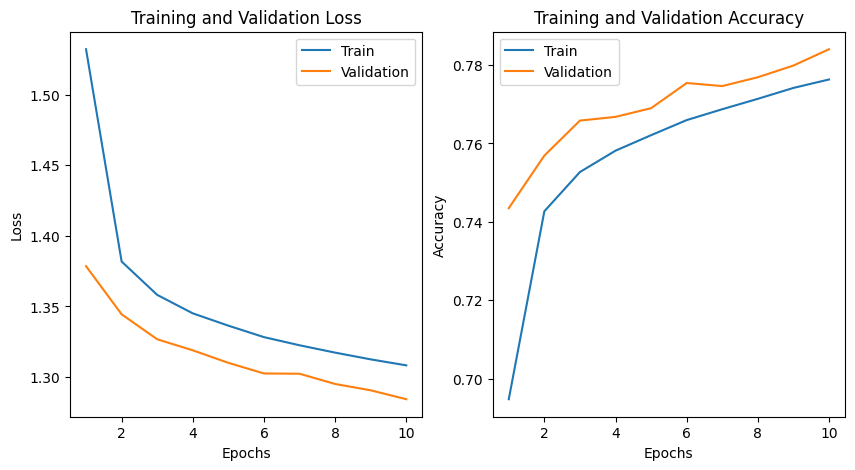

In [85]:
train_model(representation_model,
            criterion=torch.nn.NLLLoss(),
            optimizer=torch.optim.Adam(representation_model.parameters(), lr=0.01),
            train_loader=Noise_Low_t10v_train_loader,
            val_loader=Noise_Low_t10v_test_loader,
            num_epochs=10)

In [129]:
train_model(representation_model,
            criterion=torch.nn.NLLLoss(),
            optimizer=torch.optim.Adam(representation_model.parameters(), lr=0.01),
            train_loader=Noise_High_t10v_train_loader,
            val_loader=Noise_High_t10v_test_loader,
            num_epochs=1)

  0%|          | 0/195 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)